In [1]:
#Mounting on co-lab
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/Interpretable_DNN') # change folder name


Mounted at /content/drive


#### Setup of the Environment

In [2]:
#!pip install --upgrade plotly
!pip install -q -U keras-tuner --quiet

     |████████████████████████████████| 135 kB 2.1 MB/s 
     |████████████████████████████████| 1.6 MB 4.8 MB/s 


In [3]:
#Import of Libaries

import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy.ma.core import argmax

#Data Preprocessing
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.cluster import KMeans


#Model Building and Explanations
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend, Model, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
import keras_tuner as kt #hyperparameter tuning
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


#custom functions
from functions.data_proc_3 import *
from functions.experiment_setup import *
from functions.generate_inputs_3 import *


#### Functions

##### Model Building

In [4]:
#sigmoid activation function
# Instead of training another dense layer, we apply this directly upon the sum product of the thetas and explainable inputs to obtain the output

def sigmoid(x): 
    return 1.0/(1 + np.exp(-x))

#---------------------------------------------------------------------------------------------------------------------------

#Final Self Explaining Model

def self_explainable_model (indexes, args, exp_dim, lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate, cat_dynamic, num_dynamic,cat_static,num_static,opt = None, max_len = None):

  EXPERIMENT = args['experiment']
  prefix_len = args['prefix_length']

  if  max_len == None:
    MAX_LEN = args['n_size']
  else:
    MAX_LEN = max_len


  incl_time = True 
  incl_res = True
    
  dropout = 0.15
  #lstm_size_alpha =  hp.Int('units', min_value=32, max_value=512, step=32) #50
  l2reg=0.0001
  dropout_input = 0.15
  dropout_context=0.15

  dim_dynamic = 0
  for feat in cat_dynamic:
    dim_dynamic = dim_dynamic+len(indexes['dynamic_indexes'][feat+'_index'])
  dim_dynamic = dim_dynamic+len(num_dynamic)

  dim_static = 0
  for feat in cat_static:
    dim_static = dim_static+len(indexes['static_indexes'][feat+'_index'])
  dim_static = dim_static+len(num_static)

  #configuring the inputs

  raw_input = layers.Input(shape=(MAX_LEN,dim_dynamic, ), name='raw_input') #Raw input x
  #raw_input = layers.Dropout(dropout)(raw_input)

  raw_input_static = layers.Input(shape = (dim_static,), name = 'raw_input_static' ) #Static input x

  input = layers.Input(shape=(exp_dim, ), name='exp_input') #explainable input h(x)
  input = layers.Dropout(dropout,name='exp_input')(input)

  #LSTM layer with attention to process x

  alpha = layers.Bidirectional(layers.LSTM(lstm_size_alpha, return_sequences=True),
                                        name='alpha')
  alpha_dense = layers.Dense(1, kernel_regularizer=l2(l2reg))
  alpha_out = alpha(raw_input)
  alpha_out = layers.TimeDistributed(alpha_dense, name='alpha_dense')(alpha_out)
  alpha_out = layers.Softmax(name='timestep_attention', axis=1)(alpha_out)

  #second LSTM layer with attention to process x - sequential
  
  beta = layers.Bidirectional(layers.LSTM(lstm_size_beta, return_sequences=True),
                                        name='beta')
  beta_dense = layers.Dense(dim_dynamic,activation='tanh', kernel_regularizer=l2(l2reg))
  beta_out = beta(raw_input)
  beta_out = layers.TimeDistributed(beta_dense, name='beta_dense')(beta_out)
  beta_out = layers.Softmax(name='beta_timestep_attention', axis=1)(beta_out)

  #Compute context vector based on attentions and raw input x
  c_t = layers.Multiply()([alpha_out, beta_out, raw_input])
  c_t = layers.Lambda(lambda x: backend.sum(x, axis=1))(c_t)
  c_t = layers.concatenate([c_t,raw_input_static],name = 'full_features')

  #contexts = layers.Dropout(dropout)(c_t)

  #Intermediate dense layer
  dense_1_dim = round(exp_dim*dense_1_dim) 

  dense_1 = layers.Dense(dense_1_dim,
                        activation='softmax',
                        kernel_initializer='glorot_uniform',
                        name='dense_1')(c_t)

  #Dense layer to compute the explainable weights thetas

  thetas = layers.Dense(exp_dim,
                        activation='softmax',
                        kernel_initializer='glorot_uniform',
                        name='explanation_weights')(dense_1)
  #Regression layer

  reg = layers.Multiply(name = 'regression_input')([thetas, input])
  #x = layers.Lambda(lambda x: backend.sum(x, axis=1))(reg)
  #reg = layers.Dropout(dropout)(reg)

  #outcome_dim = vec['outcome'].shape[1]

  #Final Output
  #act_output = tf.math.sigmoid(x, name='act_output')

  #initialize all the weights to one
  initializer = tf.keras.initializers.Ones()  
  act_output = layers.Dense(1,activation='sigmoid',kernel_initializer=initializer,trainable=True, name='act_output')(reg)


  model = Model(inputs=[raw_input, raw_input_static, input], outputs=[thetas,act_output])

  plot_model(
        model,
        to_file="self explainable model.png",
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=96,
    )
  #learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  #optimizer choice

  if opt == 'Adam':
    optim = keras.optimizers.Adam(learning_rate=learning_rate)
  elif opt == 'Nadam':
    optim = keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  elif opt == 'Adamax':
    optim = keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  elif opt == 'Adagrad':
    optim = keras.optimizers.Adagrad(learning_rate=learning_rate, initial_accumulator_value=0.1, epsilon=1e-07)
  else:
     optim = keras.optimizers.Adam(learning_rate=learning_rate) 




  model.compile(loss={'act_output': 'binary_crossentropy'}, optimizer= optim , metrics=['accuracy']) 
  
  
  return model



#Hyperparameter tuning and returning the best model

def self_explainable_model_optimum (input_train,output_train,indexes, args, exp_dim, opt = None , max_len = None):

  if opt == None:
    opt = 'Adam'

  def model_builder(hp):

    lstm_size_alpha =  hp.Int('units', min_value=10, max_value=250, step=10)
    lstm_size_beta = hp.Int('units_beta', min_value=10, max_value=250, step=10)
    dense_1_dim = hp.Choice('units_dense_1', values=[1.2, 1.5, 2.0])
    learning_rate = 1e-2 #hp.Choice('learning_rate', values=[1e-2, 1e-3])

    model = self_explainable_model(indexes, args, exp_dim, lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate, opt, max_len)
    return model
  
  objective_fn =kt.Objective("val_act_output_accuracy", direction="max")

  tuner = kt.Hyperband(model_builder,
                     objective=objective_fn,
                     max_epochs=10,
                     factor=3,
                     directory=MY_WORKSPACE_DIR,
                     overwrite=True)
  
  early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

  tuner.search([input_train['input_dynamic'],input_train['input_static'],input_train['input_exp']], [output_train['w_output'],output_train['act_output']], epochs=50, validation_split=0.2, callbacks=[early_stopping])

  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

  model = tuner.hypermodel.build(best_hps)
  print(model.summary())

  return model

#Training the model

def self_explainable_model_fit(input_train,output_train,args, self_explainable_model, MY_WORKSPACE_DIR, batch_size, epochs):


  early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

  output_file_path = os.path.join(os.path.join(MY_WORKSPACE_DIR,
                                        'models'),'model_' +args['prediction']+
                                        '_{epoch:02d}-{val_loss:.2f}.h5')
  
  lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.5,
                                    patience=10,
                                    verbose=0,
                                    mode='auto',
                                    min_delta=0.0001,
                                    cooldown=0,
                                    min_lr=0)
  
  

  model_history = self_explainable_model.fit([input_train['input_dynamic'],input_train['input_static'],input_train['input_exp']], [output_train['w_output'],output_train['act_output']],
              validation_split=0.15,
              #validation_data=(model_val_inputs, model_val_outputs),
              verbose=1,
              callbacks=[ lr_reducer], #callbacks=[early_stopping, model_checkpoint,lr_reducer],
              batch_size=batch_size,
              epochs=epochs)
  
  return model_history
   
#-----------------------------------------------------------------------------------------------------------------------------------------------
#Plot Model History
def plot_model_history(history):
    #Training and validation curves

    plt.plot(history.history['act_output_accuracy'])
    plt.plot(history.history['val_act_output_accuracy'])
    plt.title('explainable model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()






##### Model Testing and Explanations



In [5]:

#-----------------------------------------------------------------------------------------------------------------------------------------------
#Model Testing

def test_model(input_test, output_test, exp_dim, features_exp,self_explainable_model,index_oc):

  print("Evaluate on test data")
  results = self_explainable.evaluate([input_test['input_dynamic'],input_test['input_static'],input_test['input_exp']], [output_test['w_output'],output_test['act_output']], batch_size=100)
  print("test loss, test acc:", results)
  print("\n")

  print("Classification Report")
  target_names = [index_oc[i] for i in range(len(index_oc))]
  y_test = output_test['act_output']
  y_out = self_explainable.predict([input_test['input_dynamic'],input_test['input_static'],input_test['input_exp']])
  y_pred = y_out[1]
  y_pred_bin = y_pred > 0.5
  y_pred_bin = y_pred_bin.astype(int)

  report = classification_report(y_test, y_pred_bin , target_names=target_names, output_dict=True)
  print("\n")

  '''print("Confusion Matrix")
  matrix = confusion_matrix(y_test, y_pred_bin )

  matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
  matrix_perc = matrix / matrix_sum
  df_cm = pd.DataFrame(matrix_perc, index = target_names,
                  columns = target_names)

  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)'''

  return report

#-----------------------------------------------------------------------------------------------------------------------------------------------
#Model Outputs

def model_outputs(input_test, output_test, exp_dim, features_exp,self_explainable_model):


  y_out = self_explainable_model.predict([input_test['input_dynamic'],input_test['input_static'],input_test['input_exp']])

  y_test = output_test['act_output']
  y_pred = y_out[1]
  y_pred_bin = y_pred > 0.5
  y_pred_bin = y_pred_bin.astype(int)
  y_test_exp = y_out[0]

  model_output_test ={}
  model_output_test['y_test'] = y_test
  model_output_test['y_pred'] = y_pred
  model_output_test['y_pred_bin'] = y_pred_bin
  model_output_test['y_test_exp'] = y_test_exp

  return input_test, model_output_test, features_exp



#-----------------------------------------------------------------------------------------------------------------------------------------------
#an array which identifies the closest input to the each input in the training set to compute the custom loss function

def closest_input(inputs):

  model_input_exp = inputs['input_exp']
  
  closest_input = []
  for i, x in enumerate(model_input_exp):
    error = 1000
    ind = 0
    if i == model_input_exp.shape[0]:
      for j, x_d in enumerate(model_input_exp):
        temp_error = backend.mean(backend.square(x- x_d))
        temp_ind = j
        if error > temp_error:
            error = temp_error
            ind = temp_ind
    else:
      for j, x_d in enumerate(model_input_exp[i+1:]):
        temp_error = backend.mean(backend.square(x- x_d))
        temp_ind = j+i+1
      
        if error > temp_error:
            error = temp_error
            ind = temp_ind
    closest_input = np.append(closest_input,[ind],axis = 0)

  closest_input = closest_input.astype(int)
  return closest_input



#### Experiment

##### Setting up experiment parameters

In [6]:
#Experimental parameters
prediction = 'Outcome' 
experiment =  'AG' #'AG_LS' #'AG','MS', 'IX'
timelapsed = 'total'
exp = 'EXP_2' #'EXP_0': old architecture, 'EXP_1': new architecture, 'EXP_2': Imbalanced test set

#Directories
MY_WORKSPACE_DIR = "/content/drive/My Drive/Interpretable_DNN/BPIC17_v2"
MILESTONE_DIR = "/content/drive/My Drive/Interpretable_DNN/BPIC17_v2/"+exp+'/'+experiment+'/'

#Dataset
file_name = os.path.join(MY_WORKSPACE_DIR,'BPIC_2017_OUTCOME.csv')
log_name = 'BPIC_2017'


#saving parameters to a dictionary
args = get_parameters(MILESTONE_DIR, MY_WORKSPACE_DIR, prediction, experiment, file_name, log_name,exp)



In [7]:
#Load data

log_df = pd.read_csv(args['file_name'])
log_df = log_df.reset_index(drop=True)
log_df.head()

CASEID              ACTIVITY  ACTIVITY_INDEX RESOURCE  \
0  Application_1018407971  A_Create Application               1  User_48   
1  Application_1018407971             A_Concept               2  User_48   
2  Application_1018407971            A_Accepted               3  User_48   
3  Application_1018407971        O_Create Offer               4  User_48   
4  Application_1018407971             O_Created               5  User_48   

               START_TIMESTAMP           COMPLETE_TIMESTAMP  TIME_ELAPSED  \
0  2016-05-26 22:40:20.0790000  2016-05-26 22:40:20.0790000             0   
1  2016-05-26 22:40:20.0790000  2016-05-26 22:40:20.1200000             0   
2  2016-05-26 22:40:20.1200000  2016-05-26 22:49:48.0130000             0   
3  2016-05-26 22:49:48.0130000  2016-05-26 23:06:10.0350000             0   
4  2016-05-26 23:06:10.0350000  2016-05-26 23:06:11.4870000             1   

   TASK_DURATION  CREDIT_SCORE    APP_TYPE  AMT_REQ  TERMS     OUTCOME  
0              0             0  New credit  25000.0    101  O_Accepted  
1              0             0  New credit  25000.0    101  O_Accepted  
2              0             0  New credit  25000.0    101  O_Accepted  
3              1           892  New credit  25000.0    101  O_Accepted  
4              0             0  New credit  25000.0    101  O_Accepted

In [8]:
#feature categories
cat_dynamic = ['ACTIVITY','RESOURCE']#['ACTIVITY']
num_dynamic = ['TASK_DURATION','TIME_ELAPSED','CREDIT_SCORE']  #['TIME_SPENT','TIME_ELAPSED']
cat_static = ['APP_TYPE'] 
num_static = ['AMT_REQ','TERMS'] #[]
activity_name = 'ACTIVITY'

In [9]:


for feat in cat_dynamic:
  log_df[feat] = log_df[feat].astype('category')
for feat in cat_static:
  log_df[feat] = log_df[feat].astype('category')


log_df.head()

CASEID              ACTIVITY  ACTIVITY_INDEX RESOURCE  \
0  Application_1018407971  A_Create Application               1  User_48   
1  Application_1018407971             A_Concept               2  User_48   
2  Application_1018407971            A_Accepted               3  User_48   
3  Application_1018407971        O_Create Offer               4  User_48   
4  Application_1018407971             O_Created               5  User_48   

               START_TIMESTAMP           COMPLETE_TIMESTAMP  TIME_ELAPSED  \
0  2016-05-26 22:40:20.0790000  2016-05-26 22:40:20.0790000             0   
1  2016-05-26 22:40:20.0790000  2016-05-26 22:40:20.1200000             0   
2  2016-05-26 22:40:20.1200000  2016-05-26 22:49:48.0130000             0   
3  2016-05-26 22:49:48.0130000  2016-05-26 23:06:10.0350000             0   
4  2016-05-26 23:06:10.0350000  2016-05-26 23:06:11.4870000             1   

   TASK_DURATION  CREDIT_SCORE    APP_TYPE  AMT_REQ  TERMS     OUTCOME  
0              0             0  New credit  25000.0    101  O_Accepted  
1              0             0  New credit  25000.0    101  O_Accepted  
2              0             0  New credit  25000.0    101  O_Accepted  
3              1           892  New credit  25000.0    101  O_Accepted  
4              0             0  New credit  25000.0    101  O_Accepted

##### Data Preprocessing

In [10]:
log_col = log_df.columns.tolist()
log_col.append('BUCKET')
log_col

['CASEID',
 'ACTIVITY',
 'ACTIVITY_INDEX',
 'RESOURCE',
 'START_TIMESTAMP',
 'COMPLETE_TIMESTAMP',
 'TIME_ELAPSED',
 'TASK_DURATION',
 'CREDIT_SCORE',
 'APP_TYPE',
 'AMT_REQ',
 'TERMS',
 'OUTCOME',
 'BUCKET']

In [11]:
#split test train
log_df_train, log_df_test = split_train_test(log_df, 0.15)

In [12]:

#Bucketing
n_size_ls = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

def split_bucket(log_df,log_col):
  log_df_temp = pd.DataFrame(columns = log_col)

  for i in range(len(n_size_ls)):
    df_temp = extract_prefixes(log_df,1,n_size_ls[i])
    df_temp['BUCKET'] = str(1)+'_'+str(n_size_ls[i])
    log_df_temp = pd.concat([log_df_temp,df_temp])

  return log_df_temp 

log_df_train = split_bucket(log_df_train,log_col)
log_df_test = split_bucket(log_df_test,log_col)

#Add new column to identify the resource label
log_df_train['RESOURCE'] = 'RES_' + log_df_train['RESOURCE'].astype(int,errors = 'ignore').astype(str,errors = 'ignore')
log_df_test['RESOURCE'] = 'RES_' + log_df_test['RESOURCE'].astype(int,errors = 'ignore').astype(str,errors = 'ignore')

log_df_train.head()

CASEID              ACTIVITY ACTIVITY_INDEX     RESOURCE  \
0  Application_1000334415  A_Create Application              1   RES_User_1   
1  Application_1000334415           A_Submitted              2   RES_User_1   
2  Application_1000334415             A_Concept              3   RES_User_1   
3  Application_1000334415            A_Accepted              4  RES_User_91   
4  Application_1000334415        O_Create Offer              5  RES_User_91   

               START_TIMESTAMP           COMPLETE_TIMESTAMP TIME_ELAPSED  \
0  2016-09-16 02:39:17.7580000  2016-09-16 02:39:17.7580000            0   
1  2016-09-16 02:39:17.7580000  2016-09-16 02:39:17.7930000            0   
2  2016-09-16 02:39:17.7930000  2016-09-16 02:39:41.6100000            0   
3  2016-09-16 02:39:41.6100000  2016-09-16 21:31:41.1230000            0   
4  2016-09-16 21:31:41.1230000  2016-09-16 21:35:15.4030000           19   

  TASK_DURATION CREDIT_SCORE    APP_TYPE  AMT_REQ TERMS   OUTCOME BUCKET  
0             0            0  New credit   5000.0    36  A_Denied    1_5  
1             0            0  New credit   5000.0    36  A_Denied    1_5  
2             0            0  New credit   5000.0    36  A_Denied    1_5  
3            19            0  New credit   5000.0    36  A_Denied    1_5  
4             0            1  New credit   5000.0    36  A_Denied    1_5

In [13]:
buckets = log_df_train['BUCKET'].unique().tolist()


for bucket in buckets:
  print(bucket)
  print('training dataset')
  print(log_df_train[log_df_train['BUCKET'] == bucket].groupby(['OUTCOME'])['CASEID'].nunique())
  print("")
  print('test dataset')
  print(log_df_test[log_df_test['BUCKET'] == bucket].groupby(['OUTCOME'])['CASEID'].nunique())
  print("")






1_5
training dataset
OUTCOME
A_Denied       3217
O_Accepted    14615
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_Denied       534
O_Accepted    2613
Name: CASEID, dtype: int64

1_6
training dataset
OUTCOME
A_Denied       3217
O_Accepted    14615
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_Denied       534
O_Accepted    2613
Name: CASEID, dtype: int64

1_7
training dataset
OUTCOME
A_Denied       3217
O_Accepted    14615
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_Denied       534
O_Accepted    2613
Name: CASEID, dtype: int64

1_8
training dataset
OUTCOME
A_Denied       3217
O_Accepted    14615
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_Denied       534
O_Accepted    2613
Name: CASEID, dtype: int64

1_9
training dataset
OUTCOME
A_Denied       3217
O_Accepted    14615
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_Denied       534
O_Accepted    2613
Name: CASEID, dtype: int64

1_10
training dataset
OUTCOME
A_Denied       3217
O_Accepted    14615
Name: CASE

In [14]:
#Balance only the training set and check the balance
log_df_train_temp = pd.DataFrame(columns = log_col)

for i in range(len(buckets)):
  df_temp = log_df_train[log_df_train['BUCKET'] == buckets[i]]
  a = df_temp.groupby(['OUTCOME'])['CASEID'].nunique().reset_index()
  min_ind = np.argmin(a['CASEID'])
  min_target = a['OUTCOME'][min_ind]

  df_temp = balance(df_temp,'OUTCOME',min_target,'CASEID')
  log_df_train_temp = pd.concat([log_df_train_temp,df_temp])

log_df_train = log_df_train_temp

for bucket in buckets:
  print(bucket)
  print('training dataset')
  print(log_df_train[log_df_train['BUCKET'] == bucket].groupby(['OUTCOME'])['CASEID'].nunique())
  print("")
  print('test dataset')
  print(log_df_test[log_df_test['BUCKET'] == bucket].groupby(['OUTCOME'])['CASEID'].nunique())
  print("")

1_5
training dataset
OUTCOME
A_Denied      3217
O_Accepted    3217
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_Denied       534
O_Accepted    2613
Name: CASEID, dtype: int64

1_6
training dataset
OUTCOME
A_Denied      3217
O_Accepted    3217
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_Denied       534
O_Accepted    2613
Name: CASEID, dtype: int64

1_7
training dataset
OUTCOME
A_Denied      3217
O_Accepted    3217
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_Denied       534
O_Accepted    2613
Name: CASEID, dtype: int64

1_8
training dataset
OUTCOME
A_Denied      3217
O_Accepted    3217
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_Denied       534
O_Accepted    2613
Name: CASEID, dtype: int64

1_9
training dataset
OUTCOME
A_Denied      3217
O_Accepted    3217
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_Denied       534
O_Accepted    2613
Name: CASEID, dtype: int64

1_10
training dataset
OUTCOME
A_Denied      3217
O_Accepted    3217
Name: CASEID, dtype: i

In [15]:

#------------------------------------------------------------------------------------------------
#Role discovery
#Discover roles with the training dataset

#new column 'MILESTONE' same as the activity to help running role discovery
log_df_train['MILESTONE'] = log_df_train['ACTIVITY']
log_df_test['MILESTONE'] = log_df_test['ACTIVITY']

resources, act_res_train , act_res_test = role_discovery_inputs(log_df_train,log_df_test)
roles, log_df_train = discover_roles(resources,act_res_train,log_df_train)

#assign roles 
log_df_test = assign_roles(roles,resources,act_res_test,log_df_test)

cat_dynamic = ['ACTIVITY','ROLE']

#------------------------------------------------------------------------------------------------
#Feature Encoding



def encode_features(log_df_train,log_df_test):

  indexes = {}
  dynamic_indexes = {}
  static_indexes = {}


  for feat in cat_dynamic:
    feat_index = create_index(log_df_train, feat,True)
    index_feat = {v: k for k, v in feat_index.items()}
    dynamic_indexes[feat+'_index'] = feat_index
    dynamic_indexes['index_'+feat] = index_feat
  indexes ['dynamic_indexes'] = dynamic_indexes

  for feat in cat_static:
    feat_index = create_index(log_df_train, feat,False)
    index_feat = {v: k for k, v in feat_index.items()}
    static_indexes[feat+'_index'] = feat_index
    static_indexes['index_'+feat] = index_feat
  indexes ['static_indexes'] = static_indexes

  oc_index = create_index(log_df_train, 'OUTCOME',False)
  index_oc = {v: k for k, v in oc_index.items()}
  indexes['oc_index'] = oc_index
  indexes['index_oc'] = index_oc

  #mapping the dictionary values as columns in the dataframe - train set
  for feat in cat_dynamic:
    log_df_train[feat+'_index'] = log_df_train[feat].map(indexes ['dynamic_indexes'][feat+'_index'],0)
    log_df_test[feat+'_index'] = log_df_test[feat].map(indexes ['dynamic_indexes'][feat+'_index'],0)

  for feat in cat_static:
    log_df_train[feat+'_index'] = log_df_train[feat].map(indexes ['static_indexes'][feat+'_index'],0)
    log_df_test[feat+'_index'] = log_df_test[feat].map(indexes ['static_indexes'][feat+'_index'],0)

  log_df_train['oc_index'] = log_df_train['OUTCOME'].map(indexes ['oc_index'],0)
  log_df_test['oc_index'] = log_df_test['OUTCOME'].map(indexes ['oc_index'],0)
  

  #------------------------------------------------------------------------------------------------
  #Normalizing Numerical features
  numerical_features = num_dynamic.copy()
  numerical_features.extend(num_static)

  log_df_train = normalize_events(log_df_train,args,numerical_features)
  log_df_test = normalize_events(log_df_test,args,numerical_features)

  return log_df_train, log_df_test, indexes

indexes = {}


for i in range(len(buckets)):
  df_train = log_df_train[log_df_train['BUCKET'] == buckets[i]]
  df_test = log_df_test[log_df_test['BUCKET'] == buckets[i]]  
  

  if i == 0: 
      log_df_train_temp, log_df_test_temp, bucket_index = encode_features(df_train,df_test)
      indexes[str(buckets[i])] = bucket_index
      
  else:
      df_train, df_test, bucket_index = encode_features(df_train,df_test)
      indexes[str(buckets[i])] = bucket_index
      
      log_df_train_temp = pd.concat([log_df_train_temp,df_train])
      log_df_test_temp = pd.concat([log_df_test_temp,df_test])

log_df_train = log_df_train_temp
log_df_test = log_df_test_temp

categorical_features = cat_dynamic.copy()
categorical_features.extend(cat_static)


for feat in categorical_features: 
  log_df_train[feat+'_index'] = log_df_train[feat+'_index'].fillna(0)
  log_df_test[feat+'_index'] = log_df_test[feat+'_index'].fillna(0)

<ipython-input-15-17024b56076f>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df_train[feat+'_index'] = log_df_train[feat].map(indexes ['dynamic_indexes'][feat+'_index'],0)
<ipython-input-15-17024b56076f>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df_test[feat+'_index'] = log_df_test[feat].map(indexes ['dynamic_indexes'][feat+'_index'],0)
<ipython-input-15-17024b56076f>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [16]:
#Vectorization

full_vec = {}

for i in range(len(buckets)):

  vec = {}

  df_train = log_df_train[log_df_train['BUCKET']==buckets[i]]
  df_test = log_df_test[log_df_test['BUCKET']==buckets[i]]

  print(buckets[i])

  #Reformating the event log
  log_train = reformat_events(df_train, indexes[str(buckets[i])],cat_dynamic, num_dynamic,cat_static,num_static)
  log_test = reformat_events(df_test, indexes[str(buckets[i])],cat_dynamic, num_dynamic,cat_static,num_static)

  #Obtain the maximum trc_len and cases for each set
  trc_len_train, cases_train = lengths(log_train,activity_name)
  trc_len_test, cases_test = lengths(log_test,activity_name)

  trc_len = max([trc_len_train, trc_len_test])
  print("trace_length: "+str(trc_len)+", training cases: "+str(cases_train)+", test cases: "+str(cases_test) )

  #Converting the log into a 3D Tensor
  vec_train = vectorization(log_train,indexes[str(buckets[i])],trc_len,cases_train,cat_dynamic, num_dynamic,cat_static,num_static,activity_name)
  vec_test = vectorization(log_test,indexes[str(buckets[i])],trc_len,cases_test,cat_dynamic, num_dynamic,cat_static,num_static,activity_name)

  vec['vec_train'] = vec_train
  vec['vec_test'] = vec_test

  full_vec[buckets[i]] = vec
  

  indexes[buckets[i]]['trc_len'] = trc_len
  indexes[buckets[i]]['cases_train'] = cases_train
  indexes[buckets[i]]['cases_test'] = cases_test


1_5
trace_length: 5, training cases: 6434, test cases: 3147
1_6
trace_length: 6, training cases: 6434, test cases: 3147
1_7
trace_length: 7, training cases: 6434, test cases: 3147
1_8
trace_length: 8, training cases: 6434, test cases: 3147
1_9
trace_length: 9, training cases: 6434, test cases: 3147
1_10
trace_length: 10, training cases: 6434, test cases: 3147
1_11
trace_length: 11, training cases: 6434, test cases: 3147
1_12
trace_length: 12, training cases: 6434, test cases: 3147
1_13
trace_length: 13, training cases: 6434, test cases: 3147
1_14
trace_length: 14, training cases: 6434, test cases: 3147
1_15
trace_length: 15, training cases: 6434, test cases: 3147
1_16
trace_length: 16, training cases: 6434, test cases: 3147
1_17
trace_length: 17, training cases: 6434, test cases: 3147
1_18
trace_length: 18, training cases: 6434, test cases: 3147
1_19
trace_length: 19, training cases: 6434, test cases: 3147
1_20
trace_length: 20, training cases: 6434, test cases: 3147


##### Saving Processed Data and Parameters

In [17]:
# saving the processed tensor
dirname = os.path.dirname(args['processed_vec'])
if not os.path.exists(dirname):
    os.makedirs(dirname)
with open(args['processed_vec'], 'wb') as fp:
    pickle.dump(full_vec, fp, protocol=pickle.HIGHEST_PROTOCOL)

# saving indexes
with open(args['indexes'], 'wb') as fp:
    pickle.dump(indexes, fp, protocol=pickle.HIGHEST_PROTOCOL)

#converting bucket info into a dictionary and saving
bucket_info = {}
bucket_info['buckets'] = buckets
bucket_info['n_size_ls'] = n_size_ls
with open(args['bucket_info'], 'wb') as fp:
    pickle.dump(bucket_info, fp, protocol=pickle.HIGHEST_PROTOCOL)


#saving the arguements (args)
with open(args['args'], 'wb') as fp:
    pickle.dump(args, fp, protocol=pickle.HIGHEST_PROTOCOL)

#saving event log files
file_name_train_log = os.path.join(MY_WORKSPACE_DIR+'/'+exp,log_name+'_log_df_train.csv')
log_df_train.to_csv(file_name_train_log)

file_name_test_log = os.path.join(MY_WORKSPACE_DIR+'/'+exp,log_name+'_log_df_test.csv')
log_df_test.to_csv(file_name_test_log)




##### Retrieving Saved Data and Parameters

In [ ]:
with open(args['processed_vec'], 'rb') as fp:
    full_vec = pickle.load(fp)

with open(args['indexes'], 'rb') as fp:
    indexes = pickle.load(fp)

with open(args['bucket_info'], 'rb') as fp:
    bucket_info = pickle.load(fp)

file_name_train_log = os.path.join(MY_WORKSPACE_DIR+'/'+exp,log_name+'_log_df_train.csv')
log_df_train = pd.read_csv(file_name_train_log)

file_name_test_log = os.path.join(MY_WORKSPACE_DIR+'/'+exp,log_name+'_log_df_test.csv')
log_df_test = pd.read_csv(file_name_test_log)

##### Generating Inputs

In [18]:
buckets = bucket_info['buckets']
cat_dynamic = ['ACTIVITY','ROLE']



inputs_outputs = {} #Final Dictionary with Test and Train Inputs/ Outputs for all buckets

for i in range(len(buckets)):

  vec_train = full_vec[buckets[i]]['vec_train']
  vec_test = full_vec[buckets[i]]['vec_test']

  #removing amt_req feature

  #vec_train['statics']['amt_req'] =  np.absolute(vec_train['statics']['amt_req'])*0
  #vec_test['statics']['amt_req'] =  np.absolute(vec_test['statics']['amt_req'])*0
  

  bucket = buckets[i]
  bucket_inputs_outputs  = {}

  #Inputs and Outputs -- select depending on the encoding technique
  if experiment == 'AG': 
    inputs_train, outputs_train, input_exp_dim_train, features_exp_train = generate_inputs_AG(vec_train,indexes[bucket],bucket_info['n_size_ls'][i],cat_dynamic, num_dynamic,cat_static,num_static)
    inputs_test, outputs_test, input_exp_dim_test, features_exp_test = generate_inputs_AG(vec_test,indexes[bucket],bucket_info['n_size_ls'][i],cat_dynamic, num_dynamic,cat_static,num_static)

  if experiment == 'AG_LS': 
    inputs_train, outputs_train, input_exp_dim_train, features_exp_train = generate_inputs_AG_LS(vec_train,indexes[bucket],bucket_info['n_size_ls'][i],cat_dynamic, num_dynamic,cat_static,num_static)
    inputs_test, outputs_test, input_exp_dim_test, features_exp_test = generate_inputs_AG_LS(vec_test,indexes[bucket],bucket_info['n_size_ls'][i],cat_dynamic, num_dynamic,cat_static,num_static)
  
  if experiment == 'IX': 
    inputs_train, outputs_train, input_exp_dim_train, features_exp_train = generate_inputs_IX(vec_train,indexes[bucket],bucket_info['n_size_ls'][i],cat_dynamic, num_dynamic,cat_static,num_static)
    inputs_test, outputs_test, input_exp_dim_test, features_exp_test = generate_inputs_IX(vec_test,indexes[bucket],bucket_info['n_size_ls'][i],cat_dynamic, num_dynamic,cat_static,num_static)

  features_exp = features_exp_train
  input_exp_dim = input_exp_dim_train
  if len(features_exp_test) > len(features_exp_train):
    features_exp = features_exp_test
    input_exp_dim = input_exp_dim_test

    #if training feature dimensionality < test feature dimensionalty, reshape the training feature dimensionality (this can happen when sample size is too small)
    input_exp_temp =[]
    for i in range(inputs_train['input_exp'].shape[0]):
      feat =[]
      k = 0
      for j in range(len(features_exp)):
        if features_exp[j] == features_exp_train[k]:
          feat.append(inputs_train['input_exp'][i][k])
          k = k+1
        else:
          feat.append(0)
      input_exp_temp.append(feat)
    input_exp_temp = np.asarray(input_exp_temp) 
    inputs_train['input_exp'] = input_exp_temp

  if len(features_exp_test) < len(features_exp_train):
    #if test feature dimensionality < training feature dimensionalty, reshape the test feature dimensionality (this can happen when sample size is too small)
    input_exp_temp =[]
    for i in range(inputs_test['input_exp'].shape[0]):
      feat =[]
      k = 0
      for j in range(len(features_exp)):
        if features_exp[j] == features_exp_test[k]:
          feat.append(inputs_test['input_exp'][i][k])
          k = k+1
        else:
          feat.append(0)
      input_exp_temp.append(feat)
    input_exp_temp = np.asarray(input_exp_temp) 
    inputs_test['input_exp'] = input_exp_temp

  bucket_inputs_outputs['inputs_train'] = inputs_train
  bucket_inputs_outputs['inputs_test'] = inputs_test
  bucket_inputs_outputs['outputs_train'] = outputs_train
  bucket_inputs_outputs['outputs_test'] = outputs_test
  bucket_inputs_outputs['explainable_feature_names'] = features_exp
  bucket_inputs_outputs['input_exp_dim'] = input_exp_dim

  inputs_outputs[bucket] = bucket_inputs_outputs
  
  dynamic_dim = bucket_inputs_outputs['inputs_train']['input_dynamic'].shape[2]
  try: static_dim = bucket_inputs_outputs['inputs_train']['input_static'].shape[1]
  except: static_dim  = 1

  print(bucket+' done!')
  print(dynamic_dim)
  print(static_dim)
  print(input_exp_dim)




1_5 done!
19
4
21
1_6 done!
22
4
24
1_7 done!
23
4
25
1_8 done!
25
4
27
1_9 done!
28
4
30
1_10 done!
28
4
30
1_11 done!
29
4
31
1_12 done!
29
4
31
1_13 done!
29
4
31
1_14 done!
29
4
31
1_15 done!
29
4
31
1_16 done!
29
4
31
1_17 done!
29
4
31
1_18 done!
29
4
31
1_19 done!
29
4
31
1_20 done!
29
4
31


### Model Building And Explaining


Epoch 1/100
22/22 [==============================] - 12s 164ms/step - loss: 0.6830 - act_output_loss: 0.6820 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5887 - val_loss: 0.6731 - val_act_output_loss: 0.6730 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.6304 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 2s 68ms/step - loss: 0.6625 - act_output_loss: 0.6623 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6748 - val_loss: 0.6424 - val_act_output_loss: 0.6418 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.7857 - lr: 0.0100
Epoch 3/100
22/22 [==============================] - 1s 68ms/step - loss: 0.6133 - act_output_loss: 0.6130 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.8136 - val_loss: 0.5762 - val_act_output_loss: 0.5759 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.8240 - lr: 0.0100
Epoch 4/100
22/22 [==========

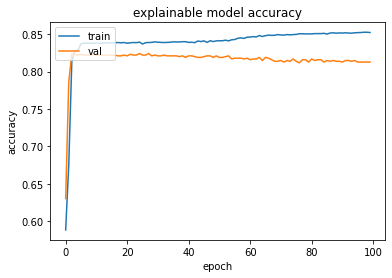

Evaluate on test data
32/32 [==============================] - 0s 13ms/step - loss: 0.5707 - act_output_loss: 0.5692 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.7407
test loss, test acc: [0.5707188844680786, 0.5691947340965271, 0.0, 0.7407054305076599]


Classification Report
99/99 [==============================] - 3s 10ms/step


99/99 [==============================] - 1s 10ms/step
Epoch 1/100
22/22 [==============================] - 14s 181ms/step - loss: 0.6865 - act_output_loss: 0.6854 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5953 - val_loss: 0.6785 - val_act_output_loss: 0.6784 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.6470 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 2s 81ms/step - loss: 0.6700 - act_output_loss: 0.6699 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6982 - val_loss: 0.6535 - val_act_output_loss: 0.6534 - val_explanation_weights_accuracy:

Evaluate on test data
32/32 [==============================] - 1s 16ms/step - loss: 0.5196 - act_output_loss: 0.5184 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.7881
test loss, test acc: [0.5195658206939697, 0.5184235572814941, 0.0, 0.7880521416664124]


Classification Report
99/99 [==============================] - 3s 7ms/step


99/99 [==============================] - 1s 7ms/step
Epoch 1/100
22/22 [==============================] - 15s 198ms/step - loss: 0.6857 - act_output_loss: 0.6845 - explanation_weights_accuracy: 0.0293 - act_output_accuracy: 0.5817 - val_loss: 0.6805 - val_act_output_loss: 0.6805 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.5818 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 2s 92ms/step - loss: 0.6700 - act_output_loss: 0.6699 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6127 - val_loss: 0.6598 - val_act_output_loss: 0.6598 - val_explanation_weights_accuracy: 0.000

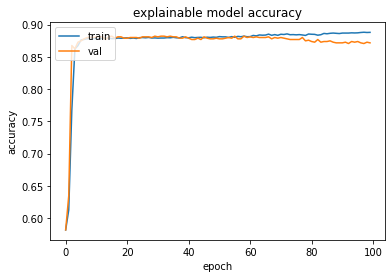

Evaluate on test data
32/32 [==============================] - 1s 18ms/step - loss: 0.4966 - act_output_loss: 0.4949 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.7995
test loss, test acc: [0.49662303924560547, 0.49493032693862915, 0.0, 0.7994915843009949]


Classification Report
99/99 [==============================] - 3s 7ms/step


99/99 [==============================] - 1s 11ms/step
Epoch 1/100
22/22 [==============================] - 13s 205ms/step - loss: 0.6872 - act_output_loss: 0.6859 - explanation_weights_accuracy: 3.6576e-04 - act_output_accuracy: 0.5689 - val_loss: 0.6817 - val_act_output_loss: 0.6816 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.5828 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 2s 109ms/step - loss: 0.6726 - act_output_loss: 0.6725 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6094 - val_loss: 0.6628 - val_act_output_loss: 0.6628 - val_explanation_weights_accurac

Evaluate on test data
32/32 [==============================] - 1s 20ms/step - loss: 0.5002 - act_output_loss: 0.4988 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.8103
test loss, test acc: [0.5001837015151978, 0.49876531958580017, 0.0, 0.8102955222129822]


Classification Report
99/99 [==============================] - 3s 8ms/step


99/99 [==============================] - 1s 8ms/step
Epoch 1/100
22/22 [==============================] - 13s 220ms/step - loss: 0.6881 - act_output_loss: 0.6867 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5668 - val_loss: 0.6837 - val_act_output_loss: 0.6837 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.5797 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 3s 118ms/step - loss: 0.6757 - act_output_loss: 0.6757 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5925 - val_loss: 0.6671 - val_act_output_loss: 0.6671 - val_explanation_weights_accuracy:

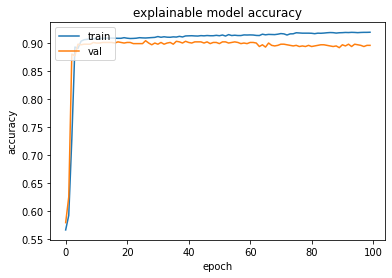

Evaluate on test data
32/32 [==============================] - 1s 22ms/step - loss: 0.4423 - act_output_loss: 0.4410 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.8503
test loss, test acc: [0.4422627091407776, 0.44102033972740173, 0.0, 0.8503336310386658]


Classification Report
99/99 [==============================] - 3s 9ms/step


99/99 [==============================] - 1s 9ms/step
Epoch 1/100
22/22 [==============================] - 15s 232ms/step - loss: 0.6878 - act_output_loss: 0.6865 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5783 - val_loss: 0.6831 - val_act_output_loss: 0.6830 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.6025 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 3s 128ms/step - loss: 0.6754 - act_output_loss: 0.6754 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5969 - val_loss: 0.6668 - val_act_output_loss: 0.6668 - val_explanation_weights_accuracy:

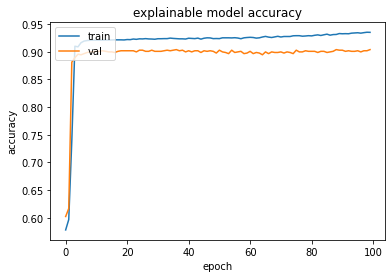

Evaluate on test data
32/32 [==============================] - 1s 25ms/step - loss: 0.4339 - act_output_loss: 0.4324 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.8672
test loss, test acc: [0.4339369237422943, 0.4324377775192261, 0.0, 0.8671751022338867]


Classification Report
99/99 [==============================] - 3s 9ms/step


99/99 [==============================] - 1s 10ms/step
Epoch 1/100
22/22 [==============================] - 15s 242ms/step - loss: 0.6888 - act_output_loss: 0.6874 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5614 - val_loss: 0.6841 - val_act_output_loss: 0.6840 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.5890 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 3s 142ms/step - loss: 0.6774 - act_output_loss: 0.6773 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6335 - val_loss: 0.6689 - val_act_output_loss: 0.6689 - val_explanation_weights_accuracy:

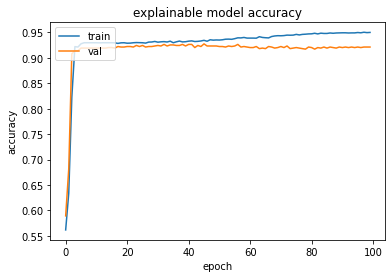

Evaluate on test data
32/32 [==============================] - 1s 26ms/step - loss: 0.4765 - act_output_loss: 0.4745 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.8780
test loss, test acc: [0.47651493549346924, 0.4745067059993744, 0.0, 0.877979040145874]


Classification Report
99/99 [==============================] - 3s 10ms/step


99/99 [==============================] - 1s 10ms/step
Epoch 1/100
22/22 [==============================] - 14s 259ms/step - loss: 0.6883 - act_output_loss: 0.6869 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5680 - val_loss: 0.6854 - val_act_output_loss: 0.6853 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.5652 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 3s 156ms/step - loss: 0.6775 - act_output_loss: 0.6774 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6273 - val_loss: 0.6709 - val_act_output_loss: 0.6709 - val_explanation_weights_accuracy

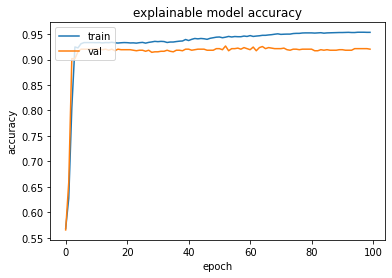

Evaluate on test data
32/32 [==============================] - 1s 29ms/step - loss: 0.4703 - act_output_loss: 0.4687 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.8888
test loss, test acc: [0.4703313410282135, 0.4687173068523407, 0.0, 0.8887829780578613]


Classification Report
99/99 [==============================] - 3s 11ms/step


99/99 [==============================] - 1s 11ms/step
Epoch 1/100
22/22 [==============================] - 16s 267ms/step - loss: 0.6879 - act_output_loss: 0.6866 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5721 - val_loss: 0.6836 - val_act_output_loss: 0.6835 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.5890 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 4s 170ms/step - loss: 0.6776 - act_output_loss: 0.6776 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6114 - val_loss: 0.6708 - val_act_output_loss: 0.6708 - val_explanation_weights_accuracy

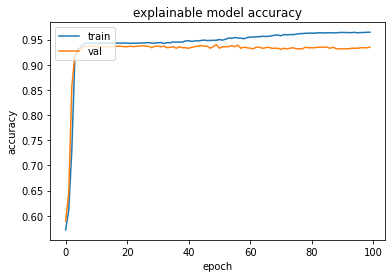

Evaluate on test data
32/32 [==============================] - 1s 31ms/step - loss: 0.4573 - act_output_loss: 0.4555 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.8999
test loss, test acc: [0.457305908203125, 0.45546019077301025, 0.0, 0.8999046683311462]


Classification Report
99/99 [==============================] - 3s 12ms/step


99/99 [==============================] - 1s 12ms/step
Epoch 1/100
22/22 [==============================] - 14s 272ms/step - loss: 0.6882 - act_output_loss: 0.6869 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5589 - val_loss: 0.6828 - val_act_output_loss: 0.6827 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.5901 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 4s 173ms/step - loss: 0.6774 - act_output_loss: 0.6773 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6006 - val_loss: 0.6700 - val_act_output_loss: 0.6699 - val_explanation_weights_accuracy

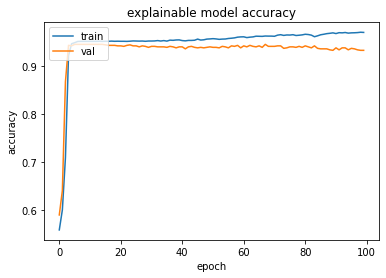

Evaluate on test data
32/32 [==============================] - 1s 33ms/step - loss: 0.4674 - act_output_loss: 0.4657 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.8945
test loss, test acc: [0.4673774838447571, 0.4657125473022461, 0.0, 0.8945026993751526]


Classification Report
99/99 [==============================] - 4s 24ms/step


99/99 [==============================] - 1s 13ms/step
Epoch 1/100
22/22 [==============================] - 15s 292ms/step - loss: 0.6870 - act_output_loss: 0.6856 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5847 - val_loss: 0.6836 - val_act_output_loss: 0.6835 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.5932 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 4s 185ms/step - loss: 0.6773 - act_output_loss: 0.6772 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5946 - val_loss: 0.6717 - val_act_output_loss: 0.6716 - val_explanation_weights_accuracy

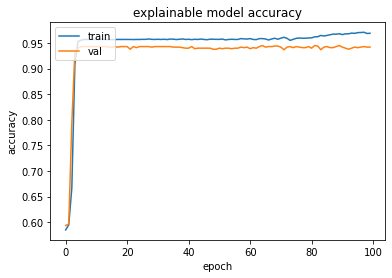

Evaluate on test data
32/32 [==============================] - 1s 35ms/step - loss: 0.3889 - act_output_loss: 0.3875 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.9180
test loss, test acc: [0.3889097273349762, 0.3874920606613159, 0.0, 0.9180171489715576]


Classification Report
99/99 [==============================] - 3s 14ms/step


99/99 [==============================] - 1s 14ms/step
Epoch 1/100
22/22 [==============================] - 16s 303ms/step - loss: 0.6881 - act_output_loss: 0.6867 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5772 - val_loss: 0.6817 - val_act_output_loss: 0.6816 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.6190 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 4s 197ms/step - loss: 0.6788 - act_output_loss: 0.6787 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6094 - val_loss: 0.6701 - val_act_output_loss: 0.6701 - val_explanation_weights_accuracy

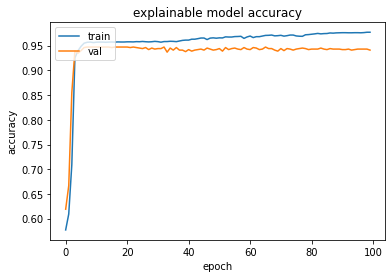

Evaluate on test data
32/32 [==============================] - 1s 38ms/step - loss: 0.4314 - act_output_loss: 0.4295 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.9180
test loss, test acc: [0.4313689172267914, 0.429491251707077, 0.0, 0.9180171489715576]


Classification Report
99/99 [==============================] - 3s 14ms/step


99/99 [==============================] - 1s 15ms/step
Epoch 1/100
22/22 [==============================] - 18s 328ms/step - loss: 0.6876 - act_output_loss: 0.6862 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5711 - val_loss: 0.6842 - val_act_output_loss: 0.6841 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.5839 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 5s 219ms/step - loss: 0.6785 - act_output_loss: 0.6784 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6075 - val_loss: 0.6732 - val_act_output_loss: 0.6732 - val_explanation_weights_accuracy:

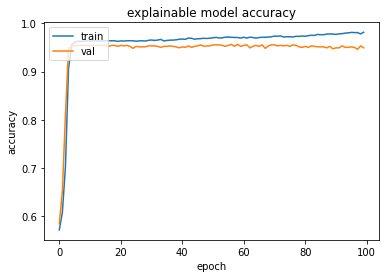

Evaluate on test data
32/32 [==============================] - 1s 41ms/step - loss: 0.4395 - act_output_loss: 0.4374 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.8653
test loss, test acc: [0.43953779339790344, 0.4374229609966278, 0.0, 0.8652685284614563]


Classification Report
99/99 [==============================] - 3s 15ms/step


99/99 [==============================] - 2s 16ms/step
Epoch 1/100
22/22 [==============================] - 18s 411ms/step - loss: 0.6873 - act_output_loss: 0.6859 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5858 - val_loss: 0.6832 - val_act_output_loss: 0.6831 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.6066 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 5s 227ms/step - loss: 0.6782 - act_output_loss: 0.6781 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5958 - val_loss: 0.6730 - val_act_output_loss: 0.6730 - val_explanation_weights_accurac

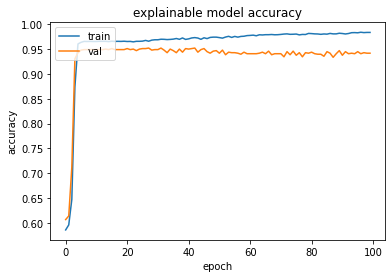

Evaluate on test data
32/32 [==============================] - 1s 42ms/step - loss: 0.4594 - act_output_loss: 0.4578 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.8389
test loss, test acc: [0.4594257175922394, 0.4577895402908325, 0.0, 0.8388941884040833]


Classification Report
99/99 [==============================] - 5s 15ms/step


99/99 [==============================] - 2s 17ms/step
Epoch 1/100
22/22 [==============================] - 16s 334ms/step - loss: 0.6879 - act_output_loss: 0.6865 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5708 - val_loss: 0.6847 - val_act_output_loss: 0.6846 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.5870 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 5s 236ms/step - loss: 0.6793 - act_output_loss: 0.6792 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5969 - val_loss: 0.6751 - val_act_output_loss: 0.6751 - val_explanation_weights_accuracy

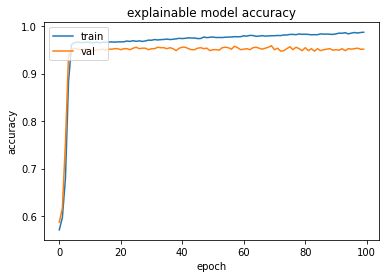

Evaluate on test data
32/32 [==============================] - 1s 45ms/step - loss: 0.4635 - act_output_loss: 0.4614 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.8201
test loss, test acc: [0.4635043144226074, 0.46143218874931335, 0.0, 0.8201461434364319]


Classification Report
99/99 [==============================] - 4s 16ms/step


99/99 [==============================] - 2s 17ms/step
Epoch 1/100
22/22 [==============================] - 17s 352ms/step - loss: 0.6883 - act_output_loss: 0.6869 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5682 - val_loss: 0.6853 - val_act_output_loss: 0.6852 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.5756 - lr: 0.0100
Epoch 2/100
22/22 [==============================] - 5s 245ms/step - loss: 0.6800 - act_output_loss: 0.6799 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5955 - val_loss: 0.6767 - val_act_output_loss: 0.6767 - val_explanation_weights_accurac

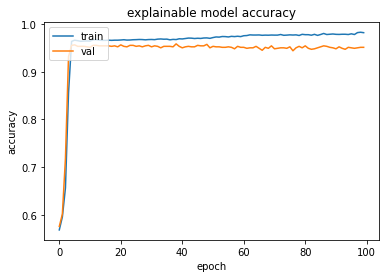

Evaluate on test data
32/32 [==============================] - 2s 49ms/step - loss: 0.4222 - act_output_loss: 0.4197 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.8993
test loss, test acc: [0.4222104847431183, 0.41973933577537537, 0.0, 0.899269163608551]


Classification Report
99/99 [==============================] - 4s 17ms/step


99/99 [==============================] - 2s 18ms/step


In [19]:
trained_models = []
hyperparametrs = []
trained_model_list = os.path.join(MILESTONE_DIR,'_model_list.pkl')

results_acc =[]
results_pre = []
results_rec = []
results_f1 = []
results_support = []

Results_df = pd.DataFrame(columns = ['BUCKET','ACCURACY','PRECISION','RECALL', 'F-1','ROC_AUC','SUPPORT'])
df_explanations = pd.DataFrame(columns = ['CASEID','FEATURE','FEATURE_VALUE','FEATURE_IMPORTANCE','BUCKET'])
df_predictions = pd.DataFrame(columns = ['CASEID','PREDICTION','GROUND_TRUTH','BUCKET'])

for i in range(len(buckets)):

  bucket = buckets[i]

  #Build Model
  max_len = full_vec[bucket]['vec_train']['prefixes'][activity_name].shape[1]
  exp_dim = inputs_outputs[bucket]['input_exp_dim']
  input_train = inputs_outputs[bucket]['inputs_train']
  output_train = inputs_outputs[bucket]['outputs_train']
  opt = 'Adam' #'Nadam','Adamax','Adagrad'

  #model with hyperparameter tuning
  #self_explainable = self_explainable_model_optimum (input_train,output_train,indexes[bucket], args,exp_dim,opt, max_len)

  #model without hyperparameter tuning

  lstm_size_alpha = 70
  lstm_size_beta = 70
  dense_1_dim = 1.5
  learning_rate = 0.01

  self_explainable = self_explainable_model(indexes[bucket], args,exp_dim, lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate, cat_dynamic, num_dynamic,cat_static,num_static,opt,max_len) 
  plot_model(
        self_explainable,
        to_file="self explainable model.png",
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=96,
    )

  #Compile Model
  lambda_reg = 0.0001

  #Train Model
  batch_size = 256 # 32, 64, 128, 256
  epochs = 100
  input_train = inputs_outputs[bucket]['inputs_train']
  output_train = inputs_outputs[bucket]['outputs_train']
  model_history = self_explainable_model_fit(input_train,output_train,args, self_explainable, MY_WORKSPACE_DIR, batch_size, epochs)
  plot_model_history(model_history) 

  output_file_path = os.path.join(MILESTONE_DIR,'_model_'+ bucket +'.pkl')
  
  # saving the trained model (for future testing)
  with open(output_file_path, 'wb') as fp:
    pickle.dump(self_explainable, fp, protocol=pickle.HIGHEST_PROTOCOL)
  
  #add the saved model name to a list (for future reference)
  trained_models.append(output_file_path)
  hyperparametrs.append(self_explainable.get_config())

  #Testing the Model and saving the macro level results as a dataframe

  input_test = inputs_outputs[bucket]['inputs_test']
  output_test = inputs_outputs[bucket]['outputs_test']
  features_exp = inputs_outputs[bucket]['explainable_feature_names']

  index_oc = indexes[bucket]['index_oc']

  report = test_model(input_test, output_test, exp_dim, features_exp,self_explainable_model,index_oc)
  #Generating Key outputs for explaining the model
  input_test, model_output_test, features_exp = model_outputs(input_test, output_test, exp_dim, features_exp,self_explainable)
  roc_auc = roc_auc_score(model_output_test['y_test'], model_output_test['y_pred'])

  Results_df_bucket = pd.DataFrame({'BUCKET': bucket,'ACCURACY': report['accuracy'],'PRECISION': report['weighted avg']['precision'],'RECALL': report['weighted avg']['recall'],
                                    'F-1': report['weighted avg']['f1-score'], 'ROC_AUC':roc_auc,'SUPPORT': report['weighted avg']['support']}, index = [i])
  Results_df = pd.concat([Results_df,Results_df_bucket])

  if bucket in ['1_5','1_10','1_15','1_20']:

    df_exp = pd.DataFrame(columns = ['CASEID','FEATURE','FEATURE_VALUE','FEATURE_IMPORTANCE','LAST_LAYER_WEIGHTS','BUCKET'])
    df_pred = pd.DataFrame(columns = ['CASEID','PREDICTION','GROUND_TRUTH','BUCKET'])

    df_exp['CASEID'] = [case  for case in full_vec[bucket]['vec_test']['caseid'] for i in range(input_test['input_exp'].shape[1])]
    df_exp['FEATURE'] = [feature for i in range(full_vec[bucket]['vec_test']['caseid'].shape[0]) for feature in features_exp ]
    df_exp['FEATURE_VALUE'] = input_test['input_exp'].flatten()
    df_exp['FEATURE_IMPORTANCE'] = model_output_test['y_test_exp'].flatten()
    df_exp['LAST_LAYER_WEIGHTS'] =  [weight for i in range(full_vec[bucket]['vec_test']['caseid'].shape[0]) for weight in self_explainable.get_layer('act_output').get_weights()[0].T[0] ]
    df_exp['BUCKET'] = [bucket  for case in full_vec[bucket]['vec_test']['caseid'] for i in range(input_test['input_exp'].shape[1])]

    df_exp['FEATURE_IMPORTANCE'] = df_exp['FEATURE_IMPORTANCE']*df_exp['LAST_LAYER_WEIGHTS'] 
    df_exp = df_exp.drop(columns = 'LAST_LAYER_WEIGHTS')

    df_pred['CASEID'] = full_vec[bucket]['vec_test']['caseid']
    df_pred['PREDICTION'] = [index_oc[int(pred>0.5)] for pred in model_output_test['y_pred'] ]
    df_pred['GROUND_TRUTH'] = [index_oc[test] for test in model_output_test['y_test'] ]
    df_pred['BUCKET'] = [bucket  for case in full_vec[bucket]['vec_test']['caseid'] ]


    df_explanations = pd.concat([df_explanations,df_exp])
    df_predictions = pd.concat([df_predictions,df_pred])

file_name_exp = os.path.join(MILESTONE_DIR,log_name+'_'+experiment+'_explanations.csv')
df_explanations.to_csv(file_name_exp)

file_name_pred = os.path.join(MILESTONE_DIR,log_name+'_'+experiment+'_predictions.csv')
df_predictions.to_csv(file_name_pred)

file_name_results = os.path.join(MILESTONE_DIR,log_name+'_'+experiment+'_results.csv')
Results_df.to_csv(file_name_results)




##### Model Results

Total Runtime of all the models is ~ 45 minutes

In [20]:
Results_df

BUCKET  ACCURACY  PRECISION    RECALL       F-1   ROC_AUC SUPPORT
0     1_5  0.740705   0.880900  0.740705  0.772434  0.868308    3147
1     1_6  0.788052   0.892432  0.788052  0.812500  0.890361    3147
2     1_7  0.799492   0.896329  0.799492  0.822183  0.895733    3147
3     1_8  0.810296   0.898965  0.810296  0.831235  0.904664    3147
4     1_9  0.850334   0.910569  0.850334  0.864858  0.917911    3147
5    1_10  0.867175   0.915813  0.867175  0.879044  0.921911    3147
6    1_11  0.877979   0.920389  0.877979  0.888308  0.911209    3147
7    1_12  0.888783   0.924595  0.888783  0.897552  0.905105    3147
8    1_13  0.899905   0.928997  0.899905  0.907103  0.915286    3147
9    1_14  0.894503   0.926958  0.894503  0.902473  0.915816    3147
10   1_15  0.918017   0.938849  0.918017  0.923109  0.951572    3147
11   1_16  0.918017   0.938338  0.918017  0.923037  0.935997    3147
12   1_17  0.865269   0.915148  0.865269  0.877429  0.936607    3147
13   1_18  0.838894   0.907841  0.838894  0.855314  0.937668    3147
14   1_19  0.820146   0.904244  0.820146  0.839724  0.946729    3147
15   1_20  0.899269   0.930165  0.899269  0.906746  0.955240    3147

### Model Evaluation

#### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

LR_Results_df = pd.DataFrame(columns = ['BUCKET','ACCURACY','PRECISION','RECALL', 'F-1', 'ROC_AUC', 'SUPPORT'])

LR_Explanations_df = pd.DataFrame (columns =  ['BUCKET','FEATURE','FEATURE_WEIGHT'] )


for i in range(len(buckets)):

  bucket = buckets[i]

  X_train = inputs_outputs[bucket]['inputs_train']['input_exp']
  y_train = inputs_outputs[bucket]['outputs_train']['act_output']

  X_test = inputs_outputs[bucket]['inputs_test']['input_exp']
  y_test = inputs_outputs[bucket]['outputs_test']['act_output']

  features_exp = inputs_outputs[bucket]['explainable_feature_names']

  LR = LogisticRegression(random_state=0,max_iter=1000).fit(X_train, y_train)

  LR_path = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),'_LR_model_'+ bucket +'.pkl')
  
  # saving the trained model (for future testing)
  with open(LR_path, 'wb') as fp:
    pickle.dump(LR, fp, protocol=pickle.HIGHEST_PROTOCOL)

  index_oc = indexes[bucket]['index_oc']
  target_names = [index_oc[i] for i in range(len(index_oc))]
  y_pred= LR.predict(X_test)
  y_pred_bin = y_pred > 0.5
  y_pred_bin = y_pred_bin.astype(int)

  report = classification_report(y_test, y_pred_bin , target_names=target_names, output_dict=True)
  roc_auc = roc_auc_score(y_test, y_pred)

  LR_Results_df_bucket = pd.DataFrame({'BUCKET': bucket,'ACCURACY': report['accuracy'],'PRECISION': report['weighted avg']['precision'],'RECALL': report['weighted avg']['recall'], 
                                       'F-1': report['weighted avg']['f1-score'], 'ROC_AUC':roc_auc,'SUPPORT': report['weighted avg']['support']}, index = [i])

  
  LR_Results_df = pd.concat([LR_Results_df,LR_Results_df_bucket])

  LR_coef = LR.coef_[0].tolist()
  LR_prediction = [index_oc[1] for f in features_exp]
  try: LR_features = features_exp.tolist()
  except: LR_features = features_exp
  LR_exp_dict = {'BUCKET': bucket,'PREDICTION':LR_prediction, 'FEATURE': LR_features,'FEATURE_IMPORTANCE': LR_coef}

  LR_Explanations_df_bucket = pd.DataFrame(LR_exp_dict)
  LR_Explanations_df = pd.concat([LR_Explanations_df,LR_Explanations_df_bucket])

file_name_LR_results = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),log_name+'_'+experiment+'_LR_results.csv')
LR_Results_df.to_csv(file_name_LR_results)

file_name_LR_explanations = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),log_name+'_'+experiment+'_LR_explanations.csv')
LR_Explanations_df.to_csv(file_name_LR_explanations)








In [25]:
LR_Results_df

BUCKET  ACCURACY  PRECISION    RECALL       F-1   ROC_AUC SUPPORT
0     1_5  0.719733   0.883834  0.719733  0.754589  0.815584    3147
1     1_6  0.762313   0.892272  0.762313  0.791086  0.842715    3147
2     1_7  0.782015   0.895354  0.782015  0.807695  0.853089    3147
3     1_8  0.795996   0.898834  0.795996  0.819486  0.862253    3147
4     1_9  0.823642   0.909096  0.823642  0.842983  0.885605    3147
5    1_10  0.847474   0.914795  0.847474  0.862967  0.898467    3147
6    1_11  0.850651   0.915366  0.850651  0.865610  0.899635    3147
7    1_12  0.870035   0.922569  0.870035  0.882122  0.913543    3147
8    1_13  0.888147   0.928393  0.888147  0.897506  0.922960    3147
9    1_14  0.891325   0.930249  0.891325  0.900308  0.926363    3147
10   1_15  0.900222   0.933222  0.900222  0.907909  0.930231    3147
11   1_16  0.908167   0.936645  0.908167  0.914806  0.935015    3147
12   1_17  0.899905   0.933688  0.899905  0.907706  0.931530    3147
13   1_18  0.914204   0.938847  0.914204  0.920010  0.937161    3147
14   1_19  0.916428   0.940705  0.916428  0.922067  0.940735    3147
15   1_20  0.919288   0.941807  0.919288  0.924547  0.941712    3147

In [26]:
LR_accuracy = sum(LR_Results_df['ACCURACY']*LR_Results_df['SUPPORT'])/sum(LR_Results_df['SUPPORT'])

In [27]:
Model_accuracy = sum(Results_df['ACCURACY']*Results_df['SUPPORT'])/sum(Results_df['SUPPORT'])

In [28]:
print('LR accuracy: '+str(LR_accuracy))
print('Model accuracy: '+str(Model_accuracy))

LR accuracy: 0.8555965999364474
Model accuracy: 0.854802192564347


####Deep learning Non Explainable

In [29]:
#Deep learning baseline model

def deep_baseline_model (indexes, args, exp_dim, lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate, cat_dynamic, num_dynamic,cat_static,num_static,opt = None, max_len = None):

  EXPERIMENT = args['experiment']
  prefix_len = args['prefix_length']

  if  max_len == None:
    MAX_LEN = args['n_size']
  else:
    MAX_LEN = max_len


  incl_time = True 
  incl_res = True
    
  dropout = 0.15
  #lstm_size_alpha =  hp.Int('units', min_value=32, max_value=512, step=32) #50
  l2reg=0.0001
  dropout_input = 0.15
  dropout_context=0.15

  dim_dynamic = 0
  for feat in cat_dynamic:
    dim_dynamic = dim_dynamic+len(indexes['dynamic_indexes'][feat+'_index'])
  dim_dynamic = dim_dynamic+len(num_dynamic)

  dim_static = 0
  for feat in cat_static:
    dim_static = dim_static+len(indexes['static_indexes'][feat+'_index'])
  dim_static = dim_static+len(num_static)
  

  #configuring the inputs

  raw_input = layers.Input(shape=(MAX_LEN,dim_dynamic, ), name='raw_input') #Raw input x
  #raw_input = layers.Dropout(dropout)(raw_input)

  raw_input_static = layers.Input(shape = (dim_static,), name = 'raw_input_static' ) #Static input x

  #input = layers.Input(shape=(exp_dim, ), name='exp_input') #explainable input h(x)
  #input = layers.Dropout(dropout,name='exp_input')(input)

  #LSTM layer with attention to process x

  alpha = layers.Bidirectional(layers.LSTM(lstm_size_alpha, return_sequences=True),
                                        name='alpha')
  alpha_dense = layers.Dense(1, kernel_regularizer=l2(l2reg))
  alpha_out = alpha(raw_input)
  alpha_out = layers.TimeDistributed(alpha_dense, name='alpha_dense')(alpha_out)
  alpha_out = layers.Softmax(name='timestep_attention', axis=1)(alpha_out)

  #second LSTM layer with attention to process x - sequential
  
  beta = layers.Bidirectional(layers.LSTM(lstm_size_beta, return_sequences=True),
                                        name='beta')
  beta_dense = layers.Dense(dim_dynamic, activation='tanh', kernel_regularizer=l2(l2reg))
  beta_out = beta(raw_input)
  beta_out = layers.TimeDistributed(beta_dense, name='beta_dense')(beta_out)
  beta_out = layers.Softmax(name='beta_timestep_attention', axis=1)(beta_out)

  #Compute context vector based on attentions and raw input x
  c_t = layers.Multiply()([alpha_out, beta_out, raw_input])
  c_t = layers.Lambda(lambda x: backend.sum(x, axis=1))(c_t)
  c_t = layers.concatenate([c_t,raw_input_static],name = 'full_features')

  #contexts = layers.Dropout(dropout)(c_t)

  '''#Intermediate dense layer
  dense_1_dim = round(exp_dim*dense_1_dim) 

  dense_1 = layers.Dense(dense_1_dim,
                        activation='softmax',
                        kernel_initializer='glorot_uniform',
                        name='dense_1')(contexts)

  #Dense layer to compute the explainable weights thetas

  thetas = layers.Dense(exp_dim,
                        activation='softmax',
                        kernel_initializer='glorot_uniform',
                        name='explanation_weights')(dense_1)'''
 
  #initialize all the weights to one
  initializer = tf.keras.initializers.Ones()  
  act_output = layers.Dense(1,activation='sigmoid',kernel_initializer=initializer,trainable=True, name='act_output')(c_t)


  model = Model(inputs=[raw_input, raw_input_static], outputs=act_output)

  #learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  #optimizer choice

  if opt == 'Adam':
    optim = keras.optimizers.Adam(learning_rate=learning_rate)
  elif opt == 'Nadam':
    optim = keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  elif opt == 'Adamax':
    optim = keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  elif opt == 'Adagrad':
    optim = keras.optimizers.Adagrad(learning_rate=learning_rate, initial_accumulator_value=0.1, epsilon=1e-07)
  else:
     optim = keras.optimizers.Adam(learning_rate=learning_rate) 




  model.compile(loss={'act_output': 'binary_crossentropy'}, optimizer= optim , metrics=['accuracy']) 
  
  
  return model

#-----------------------------------------------------------------------------------------------------------------------------------------------
  #Training the model

def deep_baseline_model_fit(input_train,output_train,args, deep_baseline_model, MY_WORKSPACE_DIR, batch_size, epochs):


  early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

  output_file_path = os.path.join(os.path.join(MY_WORKSPACE_DIR,
                                        'models'),'model_' +args['prediction']+
                                        '_{epoch:02d}-{val_loss:.2f}.h5')
  
  lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.5,
                                    patience=10,
                                    verbose=0,
                                    mode='auto',
                                    min_delta=0.0001,
                                    cooldown=0,
                                    min_lr=0)
  
  

  model_history = deep_baseline_model.fit([input_train['input_dynamic'],input_train['input_static']], output_train['act_output'],
              validation_split=0.15,
              #validation_data=(model_val_inputs, model_val_outputs),
              verbose=1,
              callbacks=[ lr_reducer], #callbacks=[early_stopping, model_checkpoint,lr_reducer],
              batch_size=batch_size,
              epochs=epochs)
  
  return model_history
   
#-----------------------------------------------------------------------------------------------------------------------------------------------
#Plot Model History
def plot_deep_baseline_model_history(history):
    #Training and validation curves

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('deep baseline model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


#-----------------------------------------------------------------------------------------------------------------------------------------------
#Model Testing
def test_deep_baseline_model(input_test, output_test, deep_baseline_model,index_oc):

  print("Evaluate on test data")
  results = deep_baseline_model.evaluate([input_test['input_dynamic'],input_test['input_static']], output_test['act_output'], batch_size=100)
  print("test loss, test acc:", results)
  print("\n")

  print("Classification Report")
  target_names = [index_oc[i] for i in range(len(index_oc))]
  y_test = output_test['act_output']
  y_out = deep_baseline_model.predict([input_test['input_dynamic'],input_test['input_static']])
  y_pred = y_out
  y_pred_bin = y_pred > 0.5
  y_pred_bin = y_pred_bin.astype(int)

  report = classification_report(y_test, y_pred_bin , target_names=target_names, output_dict=True)
  print("\n")

  '''print("Confusion Matrix")
  matrix = confusion_matrix(y_test, y_pred_bin )

  matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
  matrix_perc = matrix / matrix_sum
  df_cm = pd.DataFrame(matrix_perc, index = target_names,
                  columns = target_names)

  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)'''

  return report

###### Model Execution

Epoch 1/100
11/11 [==============================] - 13s 320ms/step - loss: 0.8708 - accuracy: 0.6079 - val_loss: 0.7104 - val_accuracy: 0.6615 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 1s 104ms/step - loss: 0.6695 - accuracy: 0.6695 - val_loss: 0.6000 - val_accuracy: 0.6905 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 1s 106ms/step - loss: 0.5819 - accuracy: 0.6889 - val_loss: 0.5303 - val_accuracy: 0.6988 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 1s 104ms/step - loss: 0.5108 - accuracy: 0.7158 - val_loss: 0.4822 - val_accuracy: 0.7215 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 1s 108ms/step - loss: 0.4667 - accuracy: 0.7418 - val_loss: 0.4482 - val_accuracy: 0.7640 - lr: 0.0100
Epoch 6/100
11/11 [==============================] - 1s 105ms/step - loss: 0.4306 - accuracy: 0.7771 - val_loss: 0.4131 - val_accuracy: 0.7930 - lr: 0.0100
Epoch 7/100
11/11 [==============================] - 1s 111ms/s

Evaluate on test data
32/32 [==============================] - 0s 13ms/step - loss: 0.4611 - accuracy: 0.7525
test loss, test acc: [0.4610738456249237, 0.7524626851081848]


Classification Report
99/99 [==============================] - 2s 6ms/step


99/99 [==============================] - 3s 6ms/step
Epoch 1/100
11/11 [==============================] - 12s 328ms/step - loss: 0.8663 - accuracy: 0.6172 - val_loss: 0.6855 - val_accuracy: 0.6770 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 1s 128ms/step - loss: 0.6213 - accuracy: 0.6913 - val_loss: 0.5458 - val_accuracy: 0.7112 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 1s 121ms/step - loss: 0.5285 - accuracy: 0.7162 - val_loss: 0.4790 - val_accuracy: 0.7298 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 1s 121ms/step - loss: 0.4700 - accuracy: 0.7379 - val_loss: 0.4278 - val_accuracy: 0.7588 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 1s 122ms/step - lo

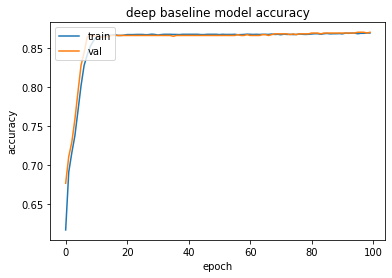

Evaluate on test data
32/32 [==============================] - 0s 14ms/step - loss: 0.4061 - accuracy: 0.7947
test loss, test acc: [0.4061311185359955, 0.7947251200675964]


Classification Report
99/99 [==============================] - 3s 7ms/step


99/99 [==============================] - 3s 7ms/step
Epoch 1/100
11/11 [==============================] - 14s 343ms/step - loss: 0.8502 - accuracy: 0.6191 - val_loss: 0.7021 - val_accuracy: 0.6677 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 2s 141ms/step - loss: 0.6397 - accuracy: 0.6904 - val_loss: 0.5760 - val_accuracy: 0.7050 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 2s 141ms/step - loss: 0.5394 - accuracy: 0.7173 - val_loss: 0.5025 - val_accuracy: 0.7184 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 2s 145ms/step - loss: 0.4747 - accuracy: 0.7372 - val_loss: 0.4468 - val_accuracy: 0.7433 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 2s 150ms/step - lo

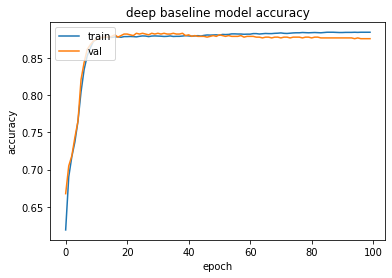

Evaluate on test data
32/32 [==============================] - 1s 19ms/step - loss: 0.3730 - accuracy: 0.8167
test loss, test acc: [0.3729710280895233, 0.8166508078575134]


Classification Report
99/99 [==============================] - 2s 7ms/step


99/99 [==============================] - 4s 7ms/step
Epoch 1/100
11/11 [==============================] - 13s 383ms/step - loss: 0.8372 - accuracy: 0.6163 - val_loss: 0.6474 - val_accuracy: 0.6957 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 2s 162ms/step - loss: 0.6076 - accuracy: 0.6940 - val_loss: 0.5265 - val_accuracy: 0.7257 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 2s 162ms/step - loss: 0.5175 - accuracy: 0.7202 - val_loss: 0.4597 - val_accuracy: 0.7391 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 2s 168ms/step - loss: 0.4563 - accuracy: 0.7429 - val_loss: 0.4111 - val_accuracy: 0.7650 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 2s 170ms/step - lo

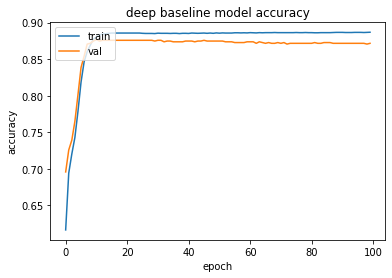

Evaluate on test data
32/32 [==============================] - 1s 19ms/step - loss: 0.3744 - accuracy: 0.8297
test loss, test acc: [0.37440869212150574, 0.8296790719032288]


Classification Report
99/99 [==============================] - 3s 8ms/step


99/99 [==============================] - 3s 13ms/step
Epoch 1/100
11/11 [==============================] - 14s 572ms/step - loss: 0.8364 - accuracy: 0.6216 - val_loss: 0.6613 - val_accuracy: 0.6998 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 2s 190ms/step - loss: 0.6050 - accuracy: 0.7010 - val_loss: 0.5473 - val_accuracy: 0.7164 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 2s 185ms/step - loss: 0.5108 - accuracy: 0.7282 - val_loss: 0.4619 - val_accuracy: 0.7350 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 2s 184ms/step - loss: 0.4332 - accuracy: 0.7610 - val_loss: 0.4053 - val_accuracy: 0.7712 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 2s 188ms/step - 

Evaluate on test data
32/32 [==============================] - 1s 22ms/step - loss: 0.3369 - accuracy: 0.8513
test loss, test acc: [0.33691728115081787, 0.8512869477272034]


Classification Report
99/99 [==============================] - 3s 9ms/step


99/99 [==============================] - 3s 9ms/step
Epoch 1/100
11/11 [==============================] - 15s 437ms/step - loss: 0.8408 - accuracy: 0.6159 - val_loss: 0.6765 - val_accuracy: 0.6925 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 2s 210ms/step - loss: 0.5998 - accuracy: 0.7096 - val_loss: 0.5437 - val_accuracy: 0.7153 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 2s 207ms/step - loss: 0.4889 - accuracy: 0.7421 - val_loss: 0.4638 - val_accuracy: 0.7402 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 2s 210ms/step - loss: 0.4228 - accuracy: 0.7701 - val_loss: 0.4075 - val_accuracy: 0.7743 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 2s 209ms/step - l

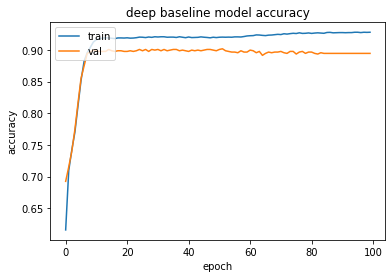

Evaluate on test data
32/32 [==============================] - 1s 23ms/step - loss: 0.2899 - accuracy: 0.8834
test loss, test acc: [0.2899315059185028, 0.8833810091018677]


Classification Report
99/99 [==============================] - 3s 9ms/step


99/99 [==============================] - 4s 9ms/step
Epoch 1/100
11/11 [==============================] - 14s 447ms/step - loss: 0.8458 - accuracy: 0.6183 - val_loss: 0.6982 - val_accuracy: 0.6791 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 2s 222ms/step - loss: 0.6141 - accuracy: 0.7041 - val_loss: 0.5626 - val_accuracy: 0.7101 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 3s 228ms/step - loss: 0.5012 - accuracy: 0.7383 - val_loss: 0.4745 - val_accuracy: 0.7319 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 3s 229ms/step - loss: 0.4292 - accuracy: 0.7690 - val_loss: 0.4109 - val_accuracy: 0.7598 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 3s 230ms/step - lo

Evaluate on test data
32/32 [==============================] - 1s 28ms/step - loss: 0.3075 - accuracy: 0.8659
test loss, test acc: [0.30747732520103455, 0.8659040331840515]


Classification Report
99/99 [==============================] - 3s 10ms/step


99/99 [==============================] - 3s 10ms/step
Epoch 1/100
11/11 [==============================] - 15s 641ms/step - loss: 0.8473 - accuracy: 0.6180 - val_loss: 0.6736 - val_accuracy: 0.6977 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 3s 260ms/step - loss: 0.6220 - accuracy: 0.7014 - val_loss: 0.5524 - val_accuracy: 0.7257 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 3s 249ms/step - loss: 0.5102 - accuracy: 0.7350 - val_loss: 0.4620 - val_accuracy: 0.7453 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 3s 248ms/step - loss: 0.4335 - accuracy: 0.7672 - val_loss: 0.4026 - val_accuracy: 0.7754 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 3s 250ms/step -

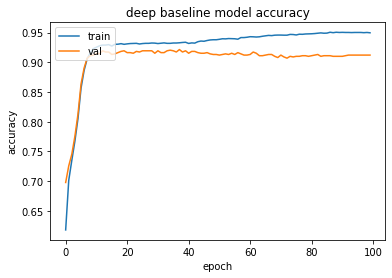

Evaluate on test data
32/32 [==============================] - 1s 28ms/step - loss: 0.2387 - accuracy: 0.9031
test loss, test acc: [0.23872873187065125, 0.9030823111534119]


Classification Report
99/99 [==============================] - 3s 11ms/step


99/99 [==============================] - 4s 18ms/step
Epoch 1/100
11/11 [==============================] - 15s 466ms/step - loss: 0.8466 - accuracy: 0.6136 - val_loss: 0.6625 - val_accuracy: 0.6988 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 3s 266ms/step - loss: 0.6183 - accuracy: 0.7074 - val_loss: 0.5348 - val_accuracy: 0.7319 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 3s 263ms/step - loss: 0.5036 - accuracy: 0.7377 - val_loss: 0.4452 - val_accuracy: 0.7536 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 3s 264ms/step - loss: 0.4268 - accuracy: 0.7665 - val_loss: 0.3844 - val_accuracy: 0.7836 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 3s 264ms/step -

Evaluate on test data
32/32 [==============================] - 1s 30ms/step - loss: 0.2105 - accuracy: 0.9237
test loss, test acc: [0.21054130792617798, 0.9237368702888489]


Classification Report
99/99 [==============================] - 4s 12ms/step


99/99 [==============================] - 3s 12ms/step
Epoch 1/100
11/11 [==============================] - 14s 496ms/step - loss: 0.8397 - accuracy: 0.6200 - val_loss: 0.6714 - val_accuracy: 0.7039 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 3s 280ms/step - loss: 0.6134 - accuracy: 0.7131 - val_loss: 0.5405 - val_accuracy: 0.7371 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 3s 290ms/step - loss: 0.5057 - accuracy: 0.7421 - val_loss: 0.4499 - val_accuracy: 0.7598 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 3s 284ms/step - loss: 0.4225 - accuracy: 0.7782 - val_loss: 0.3825 - val_accuracy: 0.7950 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 3s 283ms/step -

Evaluate on test data
32/32 [==============================] - 1s 32ms/step - loss: 0.2410 - accuracy: 0.9113
test loss, test acc: [0.24096597731113434, 0.9113441109657288]


Classification Report
99/99 [==============================] - 3s 12ms/step


99/99 [==============================] - 3s 12ms/step
Epoch 1/100
11/11 [==============================] - 15s 679ms/step - loss: 0.8227 - accuracy: 0.6269 - val_loss: 0.6836 - val_accuracy: 0.6915 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 3s 295ms/step - loss: 0.6126 - accuracy: 0.7087 - val_loss: 0.5474 - val_accuracy: 0.7340 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 3s 304ms/step - loss: 0.4912 - accuracy: 0.7451 - val_loss: 0.4400 - val_accuracy: 0.7609 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 3s 302ms/step - loss: 0.4023 - accuracy: 0.7807 - val_loss: 0.3725 - val_accuracy: 0.7981 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 3s 298ms/step -

Evaluate on test data
32/32 [==============================] - 1s 35ms/step - loss: 0.1996 - accuracy: 0.9221
test loss, test acc: [0.19958026707172394, 0.9221480488777161]


Classification Report
99/99 [==============================] - 3s 13ms/step


99/99 [==============================] - 3s 13ms/step
Epoch 1/100
11/11 [==============================] - 16s 518ms/step - loss: 0.8518 - accuracy: 0.6183 - val_loss: 0.6785 - val_accuracy: 0.6998 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 4s 323ms/step - loss: 0.6365 - accuracy: 0.7090 - val_loss: 0.5470 - val_accuracy: 0.7402 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 3s 311ms/step - loss: 0.5136 - accuracy: 0.7405 - val_loss: 0.4504 - val_accuracy: 0.7629 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 4s 322ms/step - loss: 0.4297 - accuracy: 0.7762 - val_loss: 0.3853 - val_accuracy: 0.7940 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 4s 325ms/step -

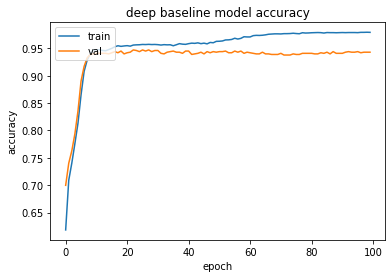

Evaluate on test data
32/32 [==============================] - 1s 35ms/step - loss: 0.1562 - accuracy: 0.9333
test loss, test acc: [0.15624184906482697, 0.9332697987556458]


Classification Report
99/99 [==============================] - 3s 13ms/step


99/99 [==============================] - 3s 13ms/step
Epoch 1/100
11/11 [==============================] - 14s 535ms/step - loss: 0.8607 - accuracy: 0.6057 - val_loss: 0.6624 - val_accuracy: 0.7112 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 4s 332ms/step - loss: 0.6302 - accuracy: 0.7090 - val_loss: 0.5351 - val_accuracy: 0.7484 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 4s 336ms/step - loss: 0.5136 - accuracy: 0.7394 - val_loss: 0.4419 - val_accuracy: 0.7692 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 4s 329ms/step - loss: 0.4258 - accuracy: 0.7772 - val_loss: 0.3753 - val_accuracy: 0.7961 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 4s 328ms/step -

Evaluate on test data
32/32 [==============================] - 1s 38ms/step - loss: 0.1566 - accuracy: 0.9314
test loss, test acc: [0.15656153857707977, 0.9313632249832153]


Classification Report
99/99 [==============================] - 3s 14ms/step


99/99 [==============================] - 3s 14ms/step
Epoch 1/100
11/11 [==============================] - 14s 567ms/step - loss: 0.8374 - accuracy: 0.6258 - val_loss: 0.6845 - val_accuracy: 0.7050 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 4s 353ms/step - loss: 0.6192 - accuracy: 0.7174 - val_loss: 0.5576 - val_accuracy: 0.7350 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 4s 358ms/step - loss: 0.5060 - accuracy: 0.7456 - val_loss: 0.4619 - val_accuracy: 0.7588 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 4s 355ms/step - loss: 0.4265 - accuracy: 0.7804 - val_loss: 0.3971 - val_accuracy: 0.7909 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 4s 357ms/step -

Evaluate on test data
32/32 [==============================] - 1s 40ms/step - loss: 0.1254 - accuracy: 0.9406
test loss, test acc: [0.12543019652366638, 0.9405783414840698]


Classification Report
99/99 [==============================] - 3s 15ms/step


99/99 [==============================] - 3s 15ms/step
Epoch 1/100
11/11 [==============================] - 14s 574ms/step - loss: 0.8402 - accuracy: 0.6253 - val_loss: 0.7005 - val_accuracy: 0.6967 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 4s 370ms/step - loss: 0.6394 - accuracy: 0.7099 - val_loss: 0.5779 - val_accuracy: 0.7308 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 4s 366ms/step - loss: 0.5339 - accuracy: 0.7383 - val_loss: 0.4845 - val_accuracy: 0.7516 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 4s 362ms/step - loss: 0.4520 - accuracy: 0.7708 - val_loss: 0.4191 - val_accuracy: 0.7795 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 4s 373ms/step -

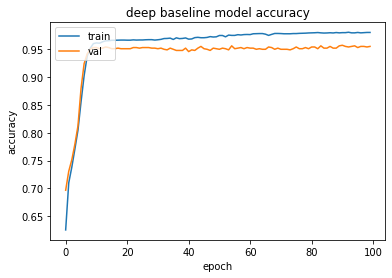

Evaluate on test data
32/32 [==============================] - 1s 43ms/step - loss: 0.1159 - accuracy: 0.9555
test loss, test acc: [0.11591342091560364, 0.9555131793022156]


Classification Report
99/99 [==============================] - 3s 15ms/step


99/99 [==============================] - 3s 16ms/step
Epoch 1/100
11/11 [==============================] - 17s 605ms/step - loss: 0.8477 - accuracy: 0.6167 - val_loss: 0.6928 - val_accuracy: 0.6988 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 4s 394ms/step - loss: 0.6367 - accuracy: 0.7114 - val_loss: 0.5666 - val_accuracy: 0.7422 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 4s 387ms/step - loss: 0.5234 - accuracy: 0.7436 - val_loss: 0.4687 - val_accuracy: 0.7578 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 4s 398ms/step - loss: 0.4379 - accuracy: 0.7767 - val_loss: 0.4016 - val_accuracy: 0.7867 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 4s 396ms/step -

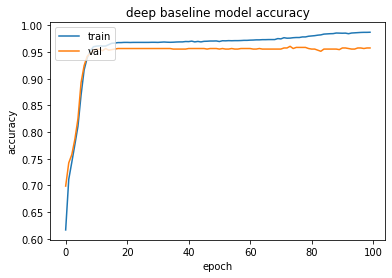

Evaluate on test data
32/32 [==============================] - 1s 46ms/step - loss: 0.1135 - accuracy: 0.9549
test loss, test acc: [0.11349953711032867, 0.9548776745796204]


Classification Report
99/99 [==============================] - 4s 18ms/step


99/99 [==============================] - 5s 16ms/step


In [30]:
trained_models = []
trained_model_list = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),'_model_list.pkl')

results_acc =[]
results_pre = []
results_rec = []
results_f1 = []
results_support = []

DL_Results_df = pd.DataFrame(columns = ['BUCKET','ACCURACY','PRECISION','RECALL', 'F-1', 'SUPPORT'])
DL_df_explanations = pd.DataFrame(columns = ['CASEID','FEATURE','FEATURE_VALUE','FEATURE_IMPORTANCE','BUCKET'])
DL_df_predictions = pd.DataFrame(columns = ['CASEID','PREDICTION','GROUND_TRUTH','BUCKET'])


for i in range(len(buckets)):

  bucket = buckets[i]

  #Build Model
  max_len = full_vec[bucket]['vec_train']['prefixes'][activity_name].shape[1]
  exp_dim = inputs_outputs[bucket]['input_exp_dim']
  input_train = inputs_outputs[bucket]['inputs_train']
  output_train = inputs_outputs[bucket]['outputs_train']
  opt = 'Adam' #'Nadam','Adamax','Adagrad'

  #model with hyperparameter tuning
  #self_explainable = self_explainable_model_optimum (input_train,output_train,indexes[bucket], args,exp_dim,opt, max_len)

  #model without hyperparameter tuning

  lstm_size_alpha = 70 #hyperparametrs[i]['layers'][1]['config']['layer']['config']['units']
  lstm_size_beta = 70 #hyperparametrs[i]['layers'][3]['config']['layer']['config']['units']
  dense_1_dim = 1.5
  learning_rate = 0.01

  deep_baseline = deep_baseline_model(indexes[bucket], args,exp_dim, lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate, cat_dynamic, num_dynamic,cat_static,num_static,opt,max_len) 
  plot_model(
        deep_baseline,
        to_file="deep_baseline_model.png",
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=96,
    )

  #Compile Model
  lambda_reg = 0.0001

  #Train Model
  batch_size = 512 # 32, 64, 128, 256
  epochs = 100
  input_train = inputs_outputs[bucket]['inputs_train']
  output_train = inputs_outputs[bucket]['outputs_train']
  model_history = deep_baseline_model_fit(input_train,output_train,args, deep_baseline, MY_WORKSPACE_DIR, batch_size, epochs)
  plot_deep_baseline_model_history(model_history) 

  output_file_path = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),'_DL_model_'+ bucket +'.pkl')
  
  # saving the trained model (for future testing)
  with open(output_file_path, 'wb') as fp:
    pickle.dump(deep_baseline, fp, protocol=pickle.HIGHEST_PROTOCOL)
  
  #add the saved model name to a list (for future reference)
  trained_models.append(output_file_path)

  #Testing the Model and saving the macro level results as a dataframe

  input_test = inputs_outputs[bucket]['inputs_test']
  output_test = inputs_outputs[bucket]['outputs_test']
  features_exp = inputs_outputs[bucket]['explainable_feature_names']

  index_oc = indexes[bucket]['index_oc']
  report = test_deep_baseline_model(input_test, output_test, deep_baseline,index_oc)

  DL_Results_df_bucket = pd.DataFrame({'BUCKET': bucket,'ACCURACY': report['accuracy'],'PRECISION': report['weighted avg']['precision'],'RECALL': report['weighted avg']['recall'], 'F-1': report['weighted avg']['f1-score'], 'SUPPORT': report['weighted avg']['support']}, index = [i])
  DL_Results_df = pd.concat([DL_Results_df,DL_Results_df_bucket])

  #Get the attention weights from the model

  model_attn_weights = Model(inputs=deep_baseline.input,
              outputs=[deep_baseline.output, deep_baseline.get_layer('timestep_attention').output,deep_baseline.get_layer('beta_timestep_attention').output])

  output_with_attention = model_attn_weights.predict([input_test['input_dynamic'],input_test['input_static']])


  #Predictions
  y_pred = output_with_attention[0]
  y_pred = [pred[0] for pred in y_pred ]
  roc_auc = roc_auc_score(full_vec[bucket]['vec_test']['outcome'], y_pred)
  DL_Results_df_bucket = pd.DataFrame({'BUCKET': bucket,'ACCURACY': report['accuracy'],'PRECISION': report['weighted avg']['precision'],
                                       'RECALL': report['weighted avg']['recall'], 
                                       'F-1': report['weighted avg']['f1-score'], 'ROC_AUC': roc_auc, 'SUPPORT': report['weighted avg']['support']}, index = [i])
  DL_Results_df = pd.concat([DL_Results_df,DL_Results_df_bucket])

  #Feature Importance
  feat_importance = output_with_attention[1]*output_with_attention[2]

  #Feature Names
  feature_names = []
  ac_names =  [item[0] for item in indexes[bucket]['dynamic_indexes']['ACTIVITY_index'].items()]
  feature_names.extend(ac_names)
  role_names = [item[0] for item in indexes[bucket]['dynamic_indexes']['ROLE_index'].items()]
  feature_names.extend(role_names)
  feature_names.extend(['t','t_dur','credit_score'])
  features_raw = [item+'_'+str(i) for i in range(input_test['input_dynamic'].shape[1]) for item in feature_names] 
  features_raw = np.asarray(features_raw)
  
  if bucket in ['1_5','1_10','1_15','1_20']:

    #df_pred
    df_pred = pd.DataFrame(columns = ['CASEID','PREDICTION','GROUND_TRUTH','BUCKET'])
    df_pred['CASEID'] = full_vec[bucket]['vec_test']['caseid']
    df_pred['PREDICTION'] = [index_oc[int(pred>0.5)] for pred in y_pred ]
    df_pred['GROUND_TRUTH'] = [index_oc[test] for test in full_vec[bucket]['vec_test']['outcome'] ]
    df_pred['BUCKET'] = bucket

    #df_exp
    df_exp = pd.DataFrame(columns = ['CASEID','FEATURE','FEATURE_VALUE','FEATURE_IMPORTANCE','BUCKET'])
    df_exp['CASEID'] = [case  for case in full_vec[bucket]['vec_test']['caseid'] for i in range(input_test['input_dynamic'].shape[1]*input_test['input_dynamic'].shape[2])]
    df_exp['FEATURE'] = [feature for i in range(full_vec[bucket]['vec_test']['caseid'].shape[0]) for feature in features_raw ]
    df_exp['FEATURE_VALUE'] = input_test['input_dynamic'].flatten()
    df_exp['FEATURE_IMPORTANCE'] = feat_importance.flatten()
    df_exp['BUCKET'] = bucket

    DL_df_explanations = pd.concat([DL_df_explanations,df_exp])
    DL_df_predictions = pd.concat([DL_df_predictions,df_pred])


file_name_exp = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),log_name+'_'+experiment+'_DL_explanations.csv')
DL_df_explanations.to_csv(file_name_exp)

file_name_pred = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),log_name+'_'+experiment+'_DL_predictions.csv')
DL_df_predictions.to_csv(file_name_pred)

file_name_results = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),log_name+'_'+experiment+'_DL_results.csv')
DL_Results_df.to_csv(file_name_results)


In [31]:
DL_Results_df

BUCKET  ACCURACY  PRECISION    RECALL       F-1 SUPPORT   ROC_AUC
0     1_5  0.752463   0.884067  0.752463  0.782458    3147       NaN
0     1_5  0.752463   0.884067  0.752463  0.782458    3147  0.867548
1     1_6  0.794725   0.893972  0.794725  0.818096    3147       NaN
1     1_6  0.794725   0.893972  0.794725  0.818096    3147  0.900079
2     1_7  0.816651   0.896308  0.816651  0.836166    3147       NaN
2     1_7  0.816651   0.896308  0.816651  0.836166    3147  0.916868
3     1_8  0.829679   0.903711  0.829679  0.847436    3147       NaN
3     1_8  0.829679   0.903711  0.829679  0.847436    3147  0.922046
4     1_9  0.851287   0.909805  0.851287  0.865544    3147       NaN
4     1_9  0.851287   0.909805  0.851287  0.865544    3147  0.938320
5    1_10  0.883381   0.920274  0.883381  0.892638    3147       NaN
5    1_10  0.883381   0.920274  0.883381  0.892638    3147  0.954622
6    1_11  0.865904   0.913694  0.865904  0.877765    3147       NaN
6    1_11  0.865904   0.913694  0.865904  0.877765    3147  0.956756
7    1_12  0.903082   0.927929  0.903082  0.909500    3147       NaN
7    1_12  0.903082   0.927929  0.903082  0.909500    3147  0.971512
8    1_13  0.923737   0.936021  0.923737  0.927227    3147       NaN
8    1_13  0.923737   0.936021  0.923737  0.927227    3147  0.976704
9    1_14  0.911344   0.934010  0.911344  0.917025    3147       NaN
9    1_14  0.911344   0.934010  0.911344  0.917025    3147  0.979313
10   1_15  0.922148   0.939721  0.922148  0.926577    3147       NaN
10   1_15  0.922148   0.939721  0.922148  0.926577    3147  0.982288
11   1_16  0.933270   0.946962  0.933270  0.936664    3147       NaN
11   1_16  0.933270   0.946962  0.933270  0.936664    3147  0.987478
12   1_17  0.931363   0.945889  0.931363  0.934956    3147       NaN
12   1_17  0.931363   0.945889  0.931363  0.934956    3147  0.988099
13   1_18  0.940578   0.951451  0.940578  0.943282    3147       NaN
13   1_18  0.940578   0.951451  0.940578  0.943282    3147  0.992943
14   1_19  0.955513   0.961275  0.955513  0.956984    3147       NaN
14   1_19  0.955513   0.961275  0.955513  0.956984    3147  0.993093
15   1_20  0.954878   0.960052  0.954878  0.956263    3147       NaN
15   1_20  0.954878   0.960052  0.954878  0.956263    3147  0.991902